In [10]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
import time
import timeit
from collections import namedtuple
import os
import glob

# from lib.tile_coding import IHT, tiles
from matplotlib import pyplot as plt
from matplotlib import cm
matplotlib.style.use('ggplot')

import io
import base64
from IPython.display import HTML

In [11]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)
    
    def fullp (self):
        return len(self.dictionary) >= self.size
    
    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

In [12]:
env = gym.make("MountainCar-v0")
env._max_episode_steps = 3000  # Increase upper time limit so we can plot full behaviour.
np.random.seed(6)  # Make plots reproducible

In [13]:
class QEstimator():
    """
    Linear action-value (q-value) function approximator for 
    semi-gradient methods with state-action featurization via tile coding. 
    """

    def __init__(self, step_size, num_tilings=8, max_size=4096, tiling_dim=None, trace=False):
        
        self.trace = trace
        self.max_size = max_size
        self.num_tilings = num_tilings
        self.tiling_dim = tiling_dim or num_tilings

        # Step size is interpreted as the fraction of the way we want 
        # to move towards the target. To compute the learning rate alpha,
        # scale by number of tilings. 
        self.alpha = step_size / num_tilings

        # Initialize index hash table (IHT) for tile coding.
        # This assigns a unique index to each tile up to max_size tiles.
        # Ensure max_size >= total number of tiles (num_tilings x tiling_dim x tiling_dim)
        # to ensure no duplicates.
        self.iht = IHT(max_size)

        # Initialize weights (and optional trace)
        self.weights = np.zeros(max_size)
        if self.trace:
            self.z = np.zeros(max_size)

        # Tilecoding software partitions at integer boundaries, so must rescale
        # position and velocity space to span tiling_dim x tiling_dim region.
        self.position_scale = self.tiling_dim / (env.observation_space.high[0] \
                                                  - env.observation_space.low[0])
        self.velocity_scale = self.tiling_dim / (env.observation_space.high[1] \
                                                  - env.observation_space.low[1])
        
    def featurize_state_action(self, state, action):
        """
        Returns the featurized representation for a 
        state-action pair.
        """
        featurized = tiles(self.iht, self.num_tilings, 
                           [self.position_scale * state[0], 
                            self.velocity_scale * state[1]], 
                           [action])
        return featurized
    
    def predict(self, s, a=None):
        """
        Predicts q-value(s) using linear FA.
        If action a is given then returns prediction
        for single state-action pair (s, a).
        Otherwise returns predictions for all actions 
        in environment paired with s.   
        """
    
        if a is None:
            features = [self.featurize_state_action(s, i) for 
                        i in range(env.action_space.n)]
        else:
            features = [self.featurize_state_action(s, a)]
            
        return [np.sum(self.weights[f]) for f in features]
        
            
    def update(self, s, a, target):
        """
        Updates the estimator parameters
        for a given state and action towards
        the target using the gradient update rule 
        (and the eligibility trace if one has been set).
        """
        features = self.featurize_state_action(s, a)
        estimation = np.sum(self.weights[features])  # Linear FA
        delta = (target - estimation)
        
        if self.trace:
            # self.z[features] += 1  # Accumulating trace
            self.z[features] = 1  # Replacing trace
            self.weights += self.alpha * delta * self.z
        else:
            self.weights[features] += self.alpha * delta
                
    
    def reset(self, z_only=False):
        """
        Resets the eligibility trace (must be done at 
        the start of every epoch) and optionally the
        weight vector (if we want to restart training
        from scratch).
        """
        
        if z_only:
            assert self.trace, 'q-value estimator has no z to reset.'
            self.z = np.zeros(self.max_size)
        else:
            if self.trace:
                self.z = np.zeros(self.max_size)
            self.weights = np.zeros(self.max_size)
        
def make_epsilon_greedy_policy(estimator, epsilon, num_actions):
    """
    Creates an epsilon-greedy policy based on a 
    given q-value approximator and epsilon.    
    """
    def policy_fn(observation):
        action_probs = np.ones(num_actions, dtype=float) * epsilon / num_actions
        q_values = estimator.predict(observation)
        best_action_idx = np.argmax(q_values)
        action_probs[best_action_idx] += (1.0 - epsilon)
        return action_probs
    return policy_fn

def sarsa_lambda(lmbda, env, estimator, gamma=1.0, epsilon=0):
    
    """
    Sarsa(Lambda) algorithm
    for finding optimal q and pi via Linear
    FA with eligibility traces.
    """
    
    # Reset the eligibility trace
    estimator.reset(z_only=True)

    # Create epsilon-greedy policy
    policy = make_epsilon_greedy_policy(
        estimator, epsilon, env.action_space.n)

    # Reset the environment and pick the first action
    state = env.reset()
    action_probs = policy(state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

    ret = 0
    # Step through episode
    for t in itertools.count():
        # Take a step
        next_state, reward, done, _ = env.step(action)
        ret += reward

        if done:
            target = reward
            estimator.update(state, action, target)
            break

        else:
            # Take next step
            next_action_probs = policy(next_state)
            next_action = np.random.choice(
                np.arange(len(next_action_probs)), p=next_action_probs)

            # Estimate q-value at next state-action
            q_new = estimator.predict(
                next_state, next_action)[0]
            target = reward + gamma * q_new
            # Update step
            estimator.update(state, action, target)
            estimator.z *= gamma * lmbda

        state = next_state
        action = next_action    
    
    return t, ret

In [14]:
def plot_cost_to_go(env, estimator, num_partitions=50):
    """
    Plots -Q(s, a_max) for each state s=(position, velocity) 
    in the environment where a_max is the maximising action 
    from s according to our q-value estimator Q.
    The state-space is continuous hence we first discretise 
    it into num_partitions partitions in each dimension. 
    """
    
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_partitions)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_partitions)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(
        lambda obs: -np.max(estimator.predict(obs)), 2, np.stack([X, Y], axis=2))

    fig, ax = plt.subplots(figsize=(10, 5))
    p = ax.pcolor(X, Y, Z, cmap=cm.RdBu, vmin=0, vmax=200)

    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_title("\"Cost To Go\" Function")
    fig.colorbar(p)
    plt.show()
def generate_greedy_policy_animation(env, estimator, save_dir):
    """
    Follows (deterministic) greedy policy
    with respect to the given q-value estimator
    and saves animation using openAI gym's Monitor 
    wrapper. Monitor will throw an error if monitor 
    files already exist in save_dir so use unique
    save_dir for each call.
    """
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    try:
        env = gym.wrappers.Monitor(
            env, save_dir, video_callable=lambda episode_id: True)
    except gym.error.Error as e:
        print(e.what())

    # Set epsilon to zero to follow greedy policy
    policy = make_epsilon_greedy_policy(
        estimator=estimator, epsilon=0, num_actions=env.action_space.n)
    # Reset the environment
    state = env.reset()
    for t in itertools.count():
        time.sleep(0.01)  # Slow down animation
        action_probs = policy(state)  # Compute action-values
        [action] = np.nonzero(action_probs)[0]  # Greedy action
        state, _, done, _ = env.step(action)  # Take step
        env.render()  # Animate
        if done:
            print('Solved in {} steps'.format(t))
            break
def display_animation(filepath):
    """ Displays mp4 animation in Jupyter."""
    
    video = io.open(filepath, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii')))
def plot_learning_curves(stats, smoothing_window=10):
    """
    Plots the number of steps taken by the agent
    to solve the task as a function of episode number,
    smoothed over the last smoothing_window episodes. 
    """
    
    plt.figure(figsize=(10,5))
    for algo_stats in stats:
        steps_per_episode = pd.Series(algo_stats.steps).rolling(
            smoothing_window).mean()  # smooth
        plt.plot(steps_per_episode, label=algo_stats.algorithm)
    plt.xlabel("Episode")
    plt.ylabel("Steps")
    plt.title("Steps per Episode")
    plt.legend()
    plt.show()
def plot_grid_search(stats, truncate_steps=400):
    """ 
    Plots average number of steps taken by the agent 
    to solve the task for each combination of
    step size and boostrapping parameter
    (n or lambda).
    """
    # Truncate high step values for clearer plotting
    stats.steps[stats.steps > truncate_steps] = truncate_steps
    
    # We use -1 step values indicate corresponding combination of
    # parameters doesn't converge. Set these to truncate_steps for plotting.
    stats.steps[stats.steps == -1] = truncate_steps
    
    plt.figure()
    for b_idx in range(len(stats.bootstrappings)):
        plt.plot(stats.step_sizes, stats.steps[b_idx, :], 
            label='Bootstrapping: {}'.format(stats.bootstrappings[b_idx]))
    plt.xlabel('Step size (alpha * number of tilings)')
    plt.ylabel('Average steps per episode')
    plt.title('Grid Search {}'.format(stats.algorithm))
    plt.ylim(140, truncate_steps - 100)
    plt.legend()

In [15]:
RunStats = namedtuple('RunStats', ['algorithm', 'steps', 'returns'])
def run(algorithm, num_episodes=500, **algorithm_kwargs):
    """
    Runs algorithm over multilple episodes and logs
    for each episode the complete return (G_t) and the
    number of steps taken.
    """
    
    stats = RunStats(
        algorithm=algorithm, 
        steps=np.zeros(num_episodes), 
        returns=np.zeros(num_episodes))
    
    algorithm_fn = globals()[algorithm]
    
    for i in range(num_episodes):
        episode_steps, episode_return = algorithm_fn(**algorithm_kwargs)
        stats.steps[i] = episode_steps
        stats.returns[i] = episode_return
        sys.stdout.flush()
        print("\rEpisode {}/{} Return {}".format(
            i + 1, num_episodes, episode_return), end="")
    return stats

Episode 500/500 Return -168.0

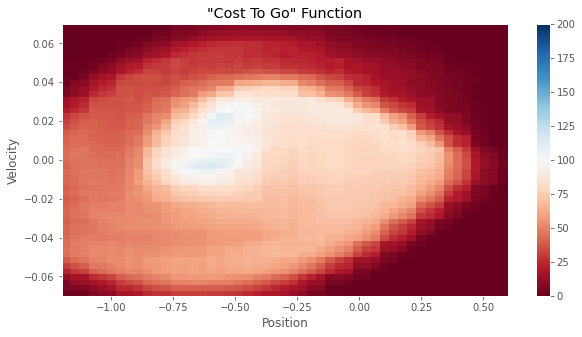

500 episodes completed in 21.82s


In [16]:
step_size = 0.5 # Fraction of the way we want to move towards target
lmbda = 0.92  # Level of bootstrapping (set to intermediate value)
num_episodes = 500

estimator_lambda = QEstimator(step_size=step_size, trace=True)

start_time = timeit.default_timer()
run_stats_lambda = run('sarsa_lambda', num_episodes, lmbda=lmbda, env=env, estimator=estimator_lambda)
elapsed_time = timeit.default_timer() - start_time

plot_cost_to_go(env, estimator_lambda)
print('{} episodes completed in {:.2f}s'.format(num_episodes, elapsed_time))

In [21]:
# Animate learned policy
# save_dir='./animations/sarsa_lambda/'
# generate_greedy_policy_animation(env, estimator_lambda, save_dir=save_dir)
# [filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
# display_animation(filepath)

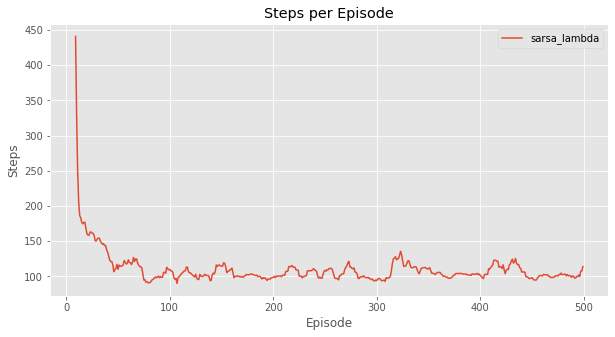

In [22]:
plot_learning_curves([run_stats_lambda])

In [23]:
GridSearchStats = namedtuple('GridSearchStats', ['algorithm', 'steps', 'step_sizes', 'bootstrappings'])

def run_grid_search(algorithm, step_sizes, bootstrappings, episodes=100, num_runs=5,
                   **algorithm_kwargs):
    """
    Runs a grid search over different values of the step size
    and boostrapping parameter (n or lambda) for the given algorithm.
    The performance of each combination of parameters is measured 
    by the number of steps taken to complete the task, averaged
    over the first episodes episodes and num_runs independent runs.
    """
    
    stats = GridSearchStats(
        algorithm=algorithm, 
        steps=np.zeros((len(bootstrappings), len(step_sizes))),
        step_sizes=step_sizes,
        bootstrappings=bootstrappings)
        
    algorithm_fn = globals()[algorithm]
    trace = True if algorithm == 'sarsa_lambda' else False

    for run_idx in range(num_runs):
        for b_idx, bootstrapping in enumerate(bootstrappings):
            for s_idx, step_size in enumerate(step_sizes):
                if algorithm == 'sarsa_n':
                    if (bootstrapping == 8 and step_size > 1) or \
                    (bootstrapping == 16 and step_size > 0.75):
                        # sarsa_n doesn't converge in these cases so 
                        # assign a default value and skip over.
                        stats.steps[b_idx, s_idx] = -1 * num_runs * episodes
                        continue
                estimator = QEstimator(step_size=step_size, trace=trace)
                for episode in range(episodes):
                    sys.stdout.flush()
                    print('\r run: {}, step_size: {}, bootstrapping: {}, episode: {}'.format(
                            run_idx, step_size, bootstrapping, episode), end="")
                    episode_steps, _ = algorithm_fn(
                        bootstrapping, estimator=estimator, **algorithm_kwargs)
                    stats.steps[b_idx, s_idx] += episode_steps
                    
    
    # Average over independent runs and episodes
    stats.steps[:] /= (num_runs * episodes)
   
    return stats

 run: 4, step_size: 1.7000000000000002, bootstrapping: 0.99, episode: 99

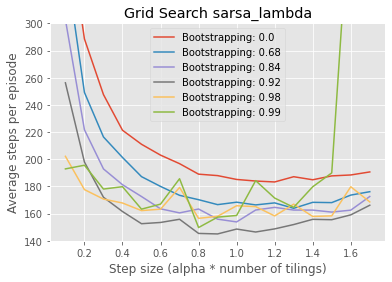

In [24]:
step_sizes = np.arange(0.1, 1.8, 0.1)
lambdas = np.array([0, 0.68, 0.84, 0.92, 0.98, 0.99])
grid_search_stats_lambda = run_grid_search('sarsa_lambda', step_sizes, lambdas, env=env)
plot_grid_search(grid_search_stats_lambda)